# TensorFlow Tutorial #05
# Ensemble Learning

## WARNING!

**This tutorial does not work with TensorFlow v. 1.9 due to the PrettyTensor builder API apparently no longer being updated and supported by the Google Developers. It is recommended that you use the _Keras API_ instead, which also makes it much easier to train or load multiple models to create an ensemble, see e.g. Tutorial #10 for inspiration on how to load and use pre-trained models using Keras.**

## Introduction

This tutorial shows how to use a so-called ensemble of convolutional neural networks. Instead of using a single neural network, we use several neural networks and average their outputs.

This is used on the MNIST data-set for recognizing hand-written digits. The ensemble improves the classification accuracy slightly on the test-set, but the difference is so small that it is possibly random. Furthermore, the ensemble mis-classifies some images that are correctly classified by some of the individual networks.

This tutorial builds on the previous tutorials, so you should have a basic understanding of TensorFlow and the add-on package Pretty Tensor. A lot of the source-code and text here is similar to the previous tutorials and may be read quickly if you have recently read the previous tutorials.

## Flowchart

The following chart shows roughly how the data flows in a single Convolutional Neural Network that is implemented below. The network has two convolutional layers and two fully-connected layers, with the last layer being used for the final classification of the input images. See Tutorial #02 for a more detailed description of this network and convolution in general.

This tutorial implements an ensemble of 5 such neural networks, where the network structure is the same but the weights and other variables are different for each network.

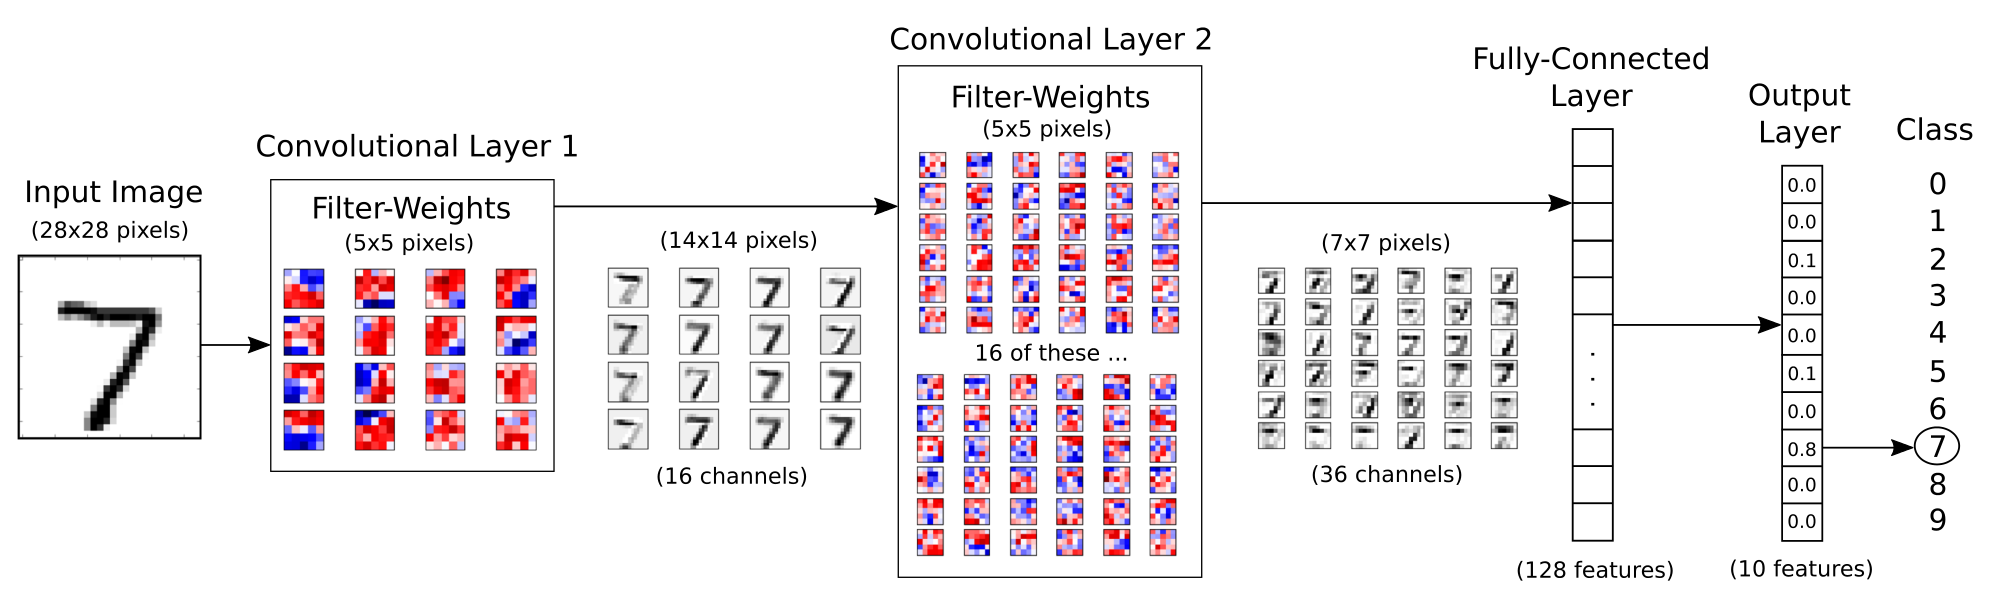

In [1]:
from IPython.display import Image
Image('images/02_network_flowchart.png')

## Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

# Use PrettyTensor to simplify Neural Network construction.
import prettytensor as pt

This was developed using Python 3.5.2 (Anaconda) and TensorFlow version:

In [3]:
tf.__version__

'0.12.0-rc0'

PrettyTensor version:

In [4]:
pt.__version__

'0.7.1'

## Load Data

The MNIST data-set is about 12 MB and will be downloaded automatically if it is not located in the given path.

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


The MNIST data-set has now been loaded and consists of 70,000 images and associated labels (i.e. classifications of the images). The data-set is split into 3 mutually exclusive sub-sets, but we will make random training-sets further below.

In [6]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


### Class numbers

The class-labels are One-Hot encoded, which means that each label is a vector with 10 elements, all of which are zero except for one element. The index of this one element is the class-number, that is, the digit shown in the associated image. We also need the class-numbers as integers for the test- and validation-sets, so we calculate them now.

In [7]:
data.test.cls = np.argmax(data.test.labels, axis=1)
data.validation.cls = np.argmax(data.validation.labels, axis=1)

### Helper-function for creating random training-sets

We will train 5 neural networks on different training-sets that are selected at random. First we combine the original training- and validation-sets into one big set. This is done for both the images and the labels.

In [8]:
combined_images = np.concatenate([data.train.images, data.validation.images], axis=0)
combined_labels = np.concatenate([data.train.labels, data.validation.labels], axis=0)

Check that the shape of the combined arrays is correct.

In [9]:
print(combined_images.shape)
print(combined_labels.shape)

(60000, 784)
(60000, 10)


Size of the combined data-set.

In [10]:
combined_size = len(combined_images)
combined_size

60000

Define the size of the training-set used for each neural network. You can try and change this.

In [11]:
train_size = int(0.8 * combined_size)
train_size

48000

We do not use a validation-set during training, but this would be the size.

In [12]:
validation_size = combined_size - train_size
validation_size

12000

Helper-function for splitting the combined data-set into a random training- and validation-set.

In [13]:
def random_training_set():
    # Create a randomized index into the full / combined training-set.
    idx = np.random.permutation(combined_size)

    # Split the random index into training- and validation-sets.
    idx_train = idx[0:train_size]
    idx_validation = idx[train_size:]

    # Select the images and labels for the new training-set.
    x_train = combined_images[idx_train, :]
    y_train = combined_labels[idx_train, :]

    # Select the images and labels for the new validation-set.
    x_validation = combined_images[idx_validation, :]
    y_validation = combined_labels[idx_validation, :]

    # Return the new training- and validation-sets.
    return x_train, y_train, x_validation, y_validation

## Data Dimensions

The data dimensions are used in several places in the source-code below. They are defined once so we can use these variables instead of numbers throughout the source-code below.

In [14]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

### Helper-function for plotting images

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [15]:
def plot_images(images,                  # Images to plot, 2-d array.
                cls_true,                # True class-no for images.
                ensemble_cls_pred=None,  # Ensemble predicted class-no.
                best_cls_pred=None):     # Best-net predicted class-no.

    assert len(images) == len(cls_true)
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if ensemble_cls_pred is None:
        hspace = 0.3
    else:
        hspace = 1.0
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # For each of the sub-plots.
    for i, ax in enumerate(axes.flat):

        # There may not be enough images for all sub-plots.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i].reshape(img_shape), cmap='binary')

            # Show true and predicted classes.
            if ensemble_cls_pred is None:
                xlabel = "True: {0}".format(cls_true[i])
            else:
                msg = "True: {0}\nEnsemble: {1}\nBest Net: {2}"
                xlabel = msg.format(cls_true[i],
                                    ensemble_cls_pred[i],
                                    best_cls_pred[i])

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct

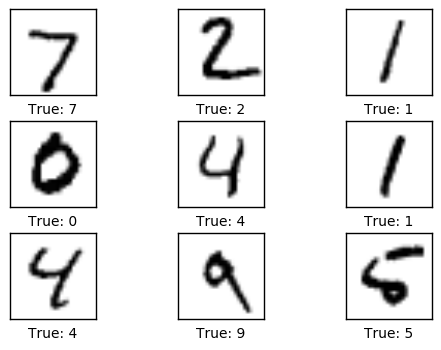

In [16]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## TensorFlow Graph

The entire purpose of TensorFlow is to have a so-called computational graph that can be executed much more efficiently than if the same calculations were to be performed directly in Python. TensorFlow can be more efficient than NumPy because TensorFlow knows the entire computation graph that must be executed, while NumPy only knows the computation of a single mathematical operation at a time.

TensorFlow can also automatically calculate the gradients that are needed to optimize the variables of the graph so as to make the model perform better. This is because the graph is a combination of simple mathematical expressions so the gradient of the entire graph can be calculated using the chain-rule for derivatives.

TensorFlow can also take advantage of multi-core CPUs as well as GPUs - and Google has even built special chips just for TensorFlow which are called TPUs (Tensor Processing Units) and are even faster than GPUs.

A TensorFlow graph consists of the following parts which will be detailed below:

* Placeholder variables used for inputting data to the graph.
* Variables that are going to be optimized so as to make the convolutional network perform better.
* The mathematical formulas for the neural network.
* A loss measure that can be used to guide the optimization of the variables.
* An optimization method which updates the variables.

In addition, the TensorFlow graph may also contain various debugging statements e.g. for logging data to be displayed using TensorBoard, which is not covered in this tutorial.

### Placeholder variables

Placeholder variables serve as the input to the TensorFlow computational graph that we may change each time we execute the graph. We call this feeding the placeholder variables and it is demonstrated further below.

First we define the placeholder variable for the input images. This allows us to change the images that are input to the TensorFlow graph. This is a so-called tensor, which just means that it is a multi-dimensional array. The data-type is set to `float32` and the shape is set to `[None, img_size_flat]`, where `None` means that the tensor may hold an arbitrary number of images with each image being a vector of length `img_size_flat`.

In [17]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

The convolutional layers expect `x` to be encoded as a 4-dim tensor so we have to reshape it so its shape is instead `[num_images, img_height, img_width, num_channels]`. Note that `img_height == img_width == img_size` and `num_images` can be inferred automatically by using -1 for the size of the first dimension. So the reshape operation is:

In [18]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable `x`. The shape of this placeholder variable is `[None, num_classes]` which means it may hold an arbitrary number of labels and each label is a vector of length `num_classes` which is 10 in this case.

In [19]:
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')

We could also have a placeholder variable for the class-number, but we will instead calculate it using argmax. Note that this is a TensorFlow operator so nothing is calculated at this point.

In [20]:
y_true_cls = tf.argmax(y_true, dimension=1)

### Neural Network

This section implements the Convolutional Neural Network using Pretty Tensor, which is much simpler than a direct implementation in TensorFlow, see Tutorial #03.

The basic idea is to wrap the input tensor `x_image` in a Pretty Tensor object which has helper-functions for adding new computational layers so as to create an entire neural network. Pretty Tensor takes care of the variable allocation, etc.

In [21]:
x_pretty = pt.wrap(x_image)

Now that we have wrapped the input image in a Pretty Tensor object, we can add the convolutional and fully-connected layers in just a few lines of source-code.

Note that `pt.defaults_scope(activation_fn=tf.nn.relu)` makes `activation_fn=tf.nn.relu` an argument for each of the layers constructed inside the `with`-block, so that Rectified Linear Units (ReLU) are used for each of these layers. The `defaults_scope` makes it easy to change arguments for all of the layers.

In [22]:
with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss = x_pretty.\
        conv2d(kernel=5, depth=16, name='layer_conv1').\
        max_pool(kernel=2, stride=2).\
        conv2d(kernel=5, depth=36, name='layer_conv2').\
        max_pool(kernel=2, stride=2).\
        flatten().\
        fully_connected(size=128, name='layer_fc1').\
        softmax_classifier(num_classes=num_classes, labels=y_true)

### Optimization Method

Pretty Tensor gave us the predicted class-label (`y_pred`) as well as a loss-measure that must be minimized, so as to improve the ability of the neural network to classify the input images.

It is unclear from the documentation for Pretty Tensor whether the loss-measure is cross-entropy or something else. But we now use the `AdamOptimizer` to minimize the loss.

Note that optimization is not performed at this point. In fact, nothing is calculated at all, we just add the optimizer-object to the TensorFlow graph for later execution.

In [23]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

### Performance Measures

We need a few more performance measures to display the progress to the user.

First we calculate the predicted class number from the output of the neural network `y_pred`, which is a vector with 10 elements. The class number is the index of the largest element.

In [24]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

Then we create a vector of booleans telling us whether the predicted class equals the true class of each image.

In [25]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

The classification accuracy is calculated by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then taking the average of these numbers.

In [26]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Saver

In order to save the variables of the neural network, we now create a Saver-object which is used for storing and retrieving all the variables of the TensorFlow graph. Nothing is actually saved at this point, which will be done further below.

Note that if you have more than 100 neural networks in the ensemble then you must increase `max_to_keep` accordingly.

In [27]:
saver = tf.train.Saver(max_to_keep=100)

This is the directory used for saving and retrieving the data.

In [28]:
save_dir = 'checkpoints/'

Create the directory if it does not exist.

In [29]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

This function returns the save-path for the data-file with the given network number.

In [30]:
def get_save_path(net_number):
    return save_dir + 'network' + str(net_number)

## TensorFlow Run

### Create TensorFlow session

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [31]:
session = tf.Session()

### Initialize variables

The variables for `weights` and `biases` must be initialized before we start optimizing them. We make a simple wrapper-function for this, because we will call it several times below.

In [32]:
def init_variables():
    session.run(tf.initialize_all_variables())

### Helper-function to create a random training batch.

There are thousands of images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore only use a small batch of images in each iteration of the optimizer.

If your computer crashes or becomes very slow because you run out of RAM, then you may try and lower this number, but you may then need to perform more optimization iterations.

In [33]:
train_batch_size = 64

Function for selecting a random training-batch of the given size.

In [34]:
def random_batch(x_train, y_train):
    # Total number of images in the training-set.
    num_images = len(x_train)

    # Create a random index into the training-set.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = x_train[idx, :]  # Images.
    y_batch = y_train[idx, :]  # Labels.

    # Return the batch.
    return x_batch, y_batch

### Helper-function to perform optimization iterations

Function for performing a number of optimization iterations so as to gradually improve the variables of the network layers. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples.  The progress is printed every 100 iterations.

In [35]:
def optimize(num_iterations, x_train, y_train):
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = random_batch(x_train, y_train)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations and after last iteration.
        if i % 100 == 0:

            # Calculate the accuracy on the training-batch.
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            
            # Status-message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Batch Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### Create ensemble of neural networks

Number of neural networks in the ensemble.

In [36]:
num_networks = 5

Number of optimization iterations for each neural network.

In [37]:
num_iterations = 10000

Create the ensemble of neural networks. All networks use the same TensorFlow graph that was defined above. For each neural network the TensorFlow weights and variables are initialized to random values and then optimized. The variables are then saved to disk so they can be reloaded later.

You may want to skip this computation if you just want to re-run the Notebook with different analysis of the results.

In [38]:
if True:
    # For each of the neural networks.
    for i in range(num_networks):
        print("Neural network: {0}".format(i))

        # Create a random training-set. Ignore the validation-set.
        x_train, y_train, _, _ = random_training_set()

        # Initialize the variables of the TensorFlow graph.
        session.run(tf.global_variables_initializer())

        # Optimize the variables using this training-set.
        optimize(num_iterations=num_iterations,
                 x_train=x_train,
                 y_train=y_train)

        # Save the optimized variables to disk.
        saver.save(sess=session, save_path=get_save_path(i))

        # Print newline.
        print()

Neural network: 0
Optimization Iteration:      1, Training Batch Accuracy:   6.2%
Optimization Iteration:    101, Training Batch Accuracy:  87.5%
Optimization Iteration:    201, Training Batch Accuracy:  92.2%
Optimization Iteration:    301, Training Batch Accuracy:  92.2%
Optimization Iteration:    401, Training Batch Accuracy:  98.4%
Optimization Iteration:    501, Training Batch Accuracy:  95.3%
Optimization Iteration:    601, Training Batch Accuracy:  95.3%
Optimization Iteration:    701, Training Batch Accuracy:  96.9%
Optimization Iteration:    801, Training Batch Accuracy:  96.9%
Optimization Iteration:    901, Training Batch Accuracy:  98.4%
Optimization Iteration:   1001, Training Batch Accuracy:  95.3%
Optimization Iteration:   1101, Training Batch Accuracy:  96.9%
Optimization Iteration:   1201, Training Batch Accuracy:  95.3%
Optimization Iteration:   1301, Training Batch Accuracy: 100.0%
Optimization Iteration:   1401, Training Batch Accuracy:  98.4%
Optimization Iteration

### Helper-functions for calculating and predicting classifications

This function calculates the predicted labels of images, that is, for each image it calculates a vector of length 10 indicating which of the 10 classes the image is.

The calculation is done in batches because it might use too much RAM otherwise. If your computer crashes then you can try and lower the batch-size.

In [39]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_labels(images):
    # Number of images.
    num_images = len(images)

    # Allocate an array for the predicted labels which
    # will be calculated in batches and filled into this array.
    pred_labels = np.zeros(shape=(num_images, num_classes),
                           dtype=np.float)

    # Now calculate the predicted labels for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images between index i and j.
        feed_dict = {x: images[i:j, :]}

        # Calculate the predicted labels using TensorFlow.
        pred_labels[i:j] = session.run(y_pred, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    return pred_labels

Calculate a boolean array whether the predicted classes for the images are correct.

In [40]:
def correct_prediction(images, labels, cls_true):
    # Calculate the predicted labels.
    pred_labels = predict_labels(images=images)

    # Calculate the predicted class-number for each image.
    cls_pred = np.argmax(pred_labels, axis=1)

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct

Calculate a boolean array whether the images in the test-set are classified correctly.

In [41]:
def test_correct():
    return correct_prediction(images = data.test.images,
                              labels = data.test.labels,
                              cls_true = data.test.cls)

Calculate a boolean array whether the images in the validation-set are classified correctly.

In [42]:
def validation_correct():
    return correct_prediction(images = data.validation.images,
                              labels = data.validation.labels,
                              cls_true = data.validation.cls)

### Helper-functions for calculating the classification accuracy

This function calculates the classification accuracy given a boolean array whether each image was correctly classified. E.g. `classification_accuracy([True, True, False, False, False]) = 2/5 = 0.4`

In [43]:
def classification_accuracy(correct):
    # When averaging a boolean array, False means 0 and True means 1.
    # So we are calculating: number of True / len(correct) which is
    # the same as the classification accuracy.
    return correct.mean()

Calculate the classification accuracy on the test-set.

In [44]:
def test_accuracy():
    # Get the array of booleans whether the classifications are correct
    # for the test-set.
    correct = test_correct()
    
    # Calculate the classification accuracy and return it.
    return classification_accuracy(correct)

Calculate the classification accuracy on the original validation-set.

In [45]:
def validation_accuracy():
    # Get the array of booleans whether the classifications are correct
    # for the validation-set.
    correct = validation_correct()
    
    # Calculate the classification accuracy and return it.
    return classification_accuracy(correct)

## Results and analysis

Function for calculating the predicted labels for all the neural networks in the ensemble. The labels are combined further below.

In [46]:
def ensemble_predictions():
    # Empty list of predicted labels for each of the neural networks.
    pred_labels = []

    # Classification accuracy on the test-set for each network.
    test_accuracies = []

    # Classification accuracy on the validation-set for each network.
    val_accuracies = []

    # For each neural network in the ensemble.
    for i in range(num_networks):
        # Reload the variables into the TensorFlow graph.
        saver.restore(sess=session, save_path=get_save_path(i))

        # Calculate the classification accuracy on the test-set.
        test_acc = test_accuracy()

        # Append the classification accuracy to the list.
        test_accuracies.append(test_acc)

        # Calculate the classification accuracy on the validation-set.
        val_acc = validation_accuracy()

        # Append the classification accuracy to the list.
        val_accuracies.append(val_acc)

        # Print status message.
        msg = "Network: {0}, Accuracy on Validation-Set: {1:.4f}, Test-Set: {2:.4f}"
        print(msg.format(i, val_acc, test_acc))

        # Calculate the predicted labels for the images in the test-set.
        # This is already calculated in test_accuracy() above but
        # it is re-calculated here to keep the code a bit simpler.
        pred = predict_labels(images=data.test.images)

        # Append the predicted labels to the list.
        pred_labels.append(pred)
    
    return np.array(pred_labels), \
           np.array(test_accuracies), \
           np.array(val_accuracies)

In [47]:
pred_labels, test_accuracies, val_accuracies = ensemble_predictions()

Network: 0, Accuracy on Validation-Set: 0.9948, Test-Set: 0.9893
Network: 1, Accuracy on Validation-Set: 0.9936, Test-Set: 0.9880
Network: 2, Accuracy on Validation-Set: 0.9958, Test-Set: 0.9893
Network: 3, Accuracy on Validation-Set: 0.9938, Test-Set: 0.9889
Network: 4, Accuracy on Validation-Set: 0.9938, Test-Set: 0.9892


Summarize the classification accuracies on the test-set for the neural networks in the ensemble.

In [48]:
print("Mean test-set accuracy: {0:.4f}".format(np.mean(test_accuracies)))
print("Min test-set accuracy:  {0:.4f}".format(np.min(test_accuracies)))
print("Max test-set accuracy:  {0:.4f}".format(np.max(test_accuracies)))

Mean test-set accuracy: 0.9889
Min test-set accuracy:  0.9880
Max test-set accuracy:  0.9893


The predicted labels of the ensemble is a 3-dim array, the first dim is the network-number, the second dim is the image-number, the third dim is the classification vector.

In [49]:
pred_labels.shape

(5, 10000, 10)

### Ensemble predictions

There are different ways to calculate the predicted labels for the ensemble. One way is to calculate the predicted class-number for each neural network, and then select the class-number with most votes. But this requires a large number of neural networks relative to the number of classes.

The method used here is instead to take the average of the predicted labels for all the networks in the ensemble. This is simple to calculate and does not require a large number of networks in the ensemble.

In [50]:
ensemble_pred_labels = np.mean(pred_labels, axis=0)
ensemble_pred_labels.shape

(10000, 10)

The ensemble's predicted class number is then the index of the highest number in the label, which is calculated using argmax as usual.

In [51]:
ensemble_cls_pred = np.argmax(ensemble_pred_labels, axis=1)
ensemble_cls_pred.shape

(10000,)

Boolean array whether each of the images in the test-set was correctly classified by the ensemble of neural networks.

In [52]:
ensemble_correct = (ensemble_cls_pred == data.test.cls)

Negate the boolean array so we can use it to lookup incorrectly classified images.

In [53]:
ensemble_incorrect = np.logical_not(ensemble_correct)

### Best neural network

Now we find the single neural network that performed best on the test-set.

First list the classification accuracies on the test-set for all the neural networks in the ensemble.

In [54]:
test_accuracies

array([ 0.9893,  0.988 ,  0.9893,  0.9889,  0.9892])

The index of the neural network with the highest classification accuracy.

In [55]:
best_net = np.argmax(test_accuracies)
best_net

0

The best neural network's classification accuracy on the test-set.

In [56]:
test_accuracies[best_net]

0.98929999999999996

Predicted labels of the best neural network.

In [57]:
best_net_pred_labels = pred_labels[best_net, :, :]

The predicted class-number.

In [58]:
best_net_cls_pred = np.argmax(best_net_pred_labels, axis=1)

Boolean array whether the best neural network classified each image in the test-set correctly.

In [59]:
best_net_correct = (best_net_cls_pred == data.test.cls)

Boolean array whether each image is incorrectly classified.

In [60]:
best_net_incorrect = np.logical_not(best_net_correct)

### Comparison of ensemble vs. the best single network

The number of images in the test-set that were correctly classified by the ensemble.

In [61]:
np.sum(ensemble_correct)

9916

The number of images in the test-set that were correctly classified by the best neural network.

In [62]:
np.sum(best_net_correct)

9893

Boolean array whether each image in the test-set was correctly classified by the ensemble and incorrectly classified by the best neural network.

In [63]:
ensemble_better = np.logical_and(best_net_incorrect,
                                 ensemble_correct)

Number of images in the test-set where the ensemble was better than the best single network:

In [64]:
ensemble_better.sum()

39

Boolean array whether each image in the test-set was correctly classified by the best single network and incorrectly classified by the ensemble.

In [65]:
best_net_better = np.logical_and(best_net_correct,
                                 ensemble_incorrect)

Number of images in the test-set where the best single network was better than the ensemble.

In [66]:
best_net_better.sum()

16

### Helper-functions for plotting and printing comparisons

Function for plotting images from the test-set and their true and predicted class-numbers.

In [67]:
def plot_images_comparison(idx):
    plot_images(images=data.test.images[idx, :],
                cls_true=data.test.cls[idx],
                ensemble_cls_pred=ensemble_cls_pred[idx],
                best_cls_pred=best_net_cls_pred[idx])

Function for printing the predicted labels.

In [68]:
def print_labels(labels, idx, num=1):
    # Select the relevant labels based on idx.
    labels = labels[idx, :]

    # Select the first num labels.
    labels = labels[0:num, :]
    
    # Round numbers to 2 decimal points so they are easier to read.
    labels_rounded = np.round(labels, 2)

    # Print the rounded labels.
    print(labels_rounded)

Function for printing the predicted labels for the ensemble of neural networks.

In [69]:
def print_labels_ensemble(idx, **kwargs):
    print_labels(labels=ensemble_pred_labels, idx=idx, **kwargs)

Function for printing the predicted labels for the best single network.

In [70]:
def print_labels_best_net(idx, **kwargs):
    print_labels(labels=best_net_pred_labels, idx=idx, **kwargs)

Function for printing the predicted labels of all the neural networks in the ensemble. This only prints the labels for the first image.

In [71]:
def print_labels_all_nets(idx):
    for i in range(num_networks):
        print_labels(labels=pred_labels[i, :, :], idx=idx, num=1)

## Examples: Ensemble is better than the best network

Plot examples of images that were correctly classified by the ensemble and incorrectly classified by the best single network.

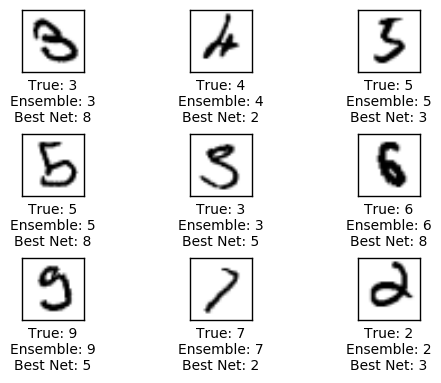

In [72]:
plot_images_comparison(idx=ensemble_better)

The ensemble's predicted labels for the first of these images (top left image):

In [73]:
print_labels_ensemble(idx=ensemble_better, num=1)

[[ 0.    0.    0.    0.76  0.    0.    0.    0.    0.23  0.  ]]


The best network's predicted labels for the first of these images:

In [74]:
print_labels_best_net(idx=ensemble_better, num=1)

[[ 0.    0.    0.    0.21  0.    0.    0.    0.    0.79  0.  ]]


The predicted labels of all the networks in the ensemble, for the first of these images:

In [75]:
print_labels_all_nets(idx=ensemble_better)

[[ 0.    0.    0.    0.21  0.    0.    0.    0.    0.79  0.  ]]
[[ 0.    0.    0.    0.96  0.    0.01  0.    0.    0.03  0.  ]]
[[ 0.    0.    0.    0.99  0.    0.    0.    0.    0.01  0.  ]]
[[ 0.    0.    0.    0.88  0.    0.    0.    0.    0.12  0.  ]]
[[ 0.    0.    0.    0.76  0.    0.01  0.    0.    0.22  0.  ]]


## Examples: Best network is better than ensemble

Now plot examples of images that were incorrectly classified by the ensemble but correctly classified by the best single network.

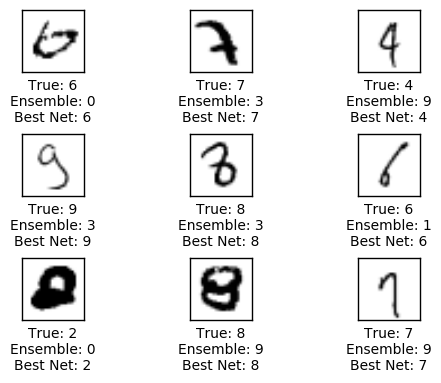

In [76]:
plot_images_comparison(idx=best_net_better)

The ensemble's predicted labels for the first of these images (top left image):

In [77]:
print_labels_ensemble(idx=best_net_better, num=1)

[[ 0.5   0.    0.    0.    0.    0.05  0.45  0.    0.    0.  ]]


The best single network's predicted labels for the first of these images:

In [78]:
print_labels_best_net(idx=best_net_better, num=1)

[[ 0.3   0.    0.    0.    0.    0.15  0.56  0.    0.    0.  ]]


The predicted labels of all the networks in the ensemble, for the first of these images:

In [79]:
print_labels_all_nets(idx=best_net_better)

[[ 0.3   0.    0.    0.    0.    0.15  0.56  0.    0.    0.  ]]
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.19  0.    0.    0.    0.    0.    0.81  0.    0.    0.  ]]
[[ 0.15  0.    0.    0.    0.    0.12  0.72  0.    0.    0.  ]]
[[ 0.85  0.    0.    0.    0.    0.    0.14  0.    0.    0.  ]]


## Close TensorFlow Session

We are now done using TensorFlow, so we close the session to release its resources.

In [80]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()

## Conclusion

This tutorial created an ensemble of 5 convolutional neural networks for classifying hand-written digits in the MNIST data-set. The ensemble worked by averaging the predicted class-labels of the 5 individual neural networks. This resulted in slightly improved classification accuracy on the test-set, with the ensemble having an accuracy of 99.1% compared to 98.9% for the best individual network.

However, the ensemble did not always perform better than the individual neural networks, which sometimes classified images correctly while the ensemble misclassified those images. This suggests that the effect of using an ensemble of neural networks is somewhat random and may not provide a reliable way of improving the performance over a single neural network.

The form of ensemble learning used here is called [bagging](https://en.wikipedia.org/wiki/Bootstrap_aggregating) (or Bootstrap Aggregating), which is mainly useful for avoiding overfitting and may not be necessary for this particular neural network and data-set. So it is still possible that ensemble learning may work in other settings.

### Technical Note

This implementation of ensemble learning used the TensorFlow `Saver()`-object to save and reload the variables of the neural network. But this functionality was really designed for another purpose and becomes very awkward to use for ensemble learning with different types of neural networks, or if you want to load multiple neural networks at the same time. There's an add-on package for TensorFlow called [sk-flow](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/learn/python/learn) which makes this much easier, but it is still in the early stages of development as of August 2016.

## Exercises

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook before making any changes.

* Change different aspects of this program to see how it affects the performance:
    * Use more neural networks in the ensemble.
    * Change the size of the training-sets.
    * Change the number of optimization iterations, try both more and less.
* Explain to a friend how the program works.
* Do you think Ensemble Learning is worth more research effort, or should you rather focus on improving a single neural network?